In [1]:
EXP_NAME = "EXP_0_1"
MODEL_NAME = "CNN"

In [2]:
import torch; torch.manual_seed(0)
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader,random_split, ConcatDataset
from function.Dir import Dir
from function.ssim_torch import ssim_function
from function.jsdiv import jsdiv 
from function.Dataset import ImageDataset
from function.Loss import Custom_criterion
from function.Log import log
import torch.nn.functional as F
import importlib

Model_module = importlib.import_module('function.%s_%s'%(MODEL_NAME,EXP_NAME))
Model = getattr(Model_module, MODEL_NAME)

filepath = "/root/autodl-fs/SimulatedData/poisson_src_bkg.pkl.npy"

traintype='poissonsrc+bkg_highresorig'
filetmp = np.load(filepath,allow_pickle=True)
filelen = filetmp.shape[0]
del filetmp
print(filelen)
frac_train = 0.8
NUM_TO_LEARN = int(filelen)

if "supplementpath" in locals():
    filetmp = np.load(supplementpath,allow_pickle=True)
    supplen = filetmp.shape[0]
    del filetmp
    print(supplen)
    NUM_SUPP = int(supplen)


EPOCHS = 400 #参数1
BATCH_SIZE = 32 #参数2
LATENTDIM = 64 #参数3
LR_MAX = 5e-4
LR_MIN = 5e-6
mode = 1 #0代表STED_HC文件训练，1代表使用STED，对应ImageDataset里的 mode 参数。（STED出的模型对泛化能力弱，STED_HC对训练集的还原会有点失真）

DEVICE = 'cuda'
LOSS_PLOT = []
TESTLOSS_PLOT = []
EPOCH_PLOT = []

7000


In [3]:
name = f'{EPOCHS}epo_{BATCH_SIZE}bth_{LATENTDIM}latn_{traintype}'

#加载数据集
'''生成数据集，注意种子要保存好，不然测试无法复现测试集。'''
dataset = ImageDataset(NUM_TO_LEARN, mode,filepath)


trainset, testset = random_split(dataset,
                                            lengths=[int(frac_train *len(dataset)),
                                            len(dataset) - int(frac_train * len(dataset))],
                                            generator=torch.Generator().manual_seed(0))
if "supplementpath" in locals():
    supplementset = ImageDataset(NUM_SUPP,mode,supplementpath)
    trainset = ConcatDataset([trainset,supplementset])

dataloader = DataLoader(trainset,shuffle=True,batch_size=BATCH_SIZE)
testloader = DataLoader(testset,shuffle=True,batch_size=BATCH_SIZE)
#初始化VAE网络
model = Model(LATENTDIM).to(DEVICE)
#model.reset_parameters()
#model = nn.DataParallel(model) #将 VAE 包装成一个并行化模型，以便在多个 GPU 上并行地进行训练

#定义LOSS函数与优化器
#criterion1 = jsdiv#ssim_function#nn.MSELoss()
#criterion2 = jsdiv#ssim_function#Custom_criterion().cuda()
def lossfunction(img1,img2):
    mse = nn.MSELoss()
    loss = mse(img1,img2)*0.2+jsdiv(img1,img2)*0.8
    return loss
#lossfunction = nn.MSELoss()#jsdiv#ssim_function
optimizer = torch.optim.AdamW(model.parameters(), lr = LR_MAX)

In [4]:
# 打印数据集中的一些样本
for batch_idx, (blurry_img, original_img) in enumerate(dataloader):
    continue
    print(f"Batch {batch_idx + 1}:")
    print(f"Blurry image shape: {blurry_img.shape}")
    print(f"Original image shape: {original_img.shape}")
blurry_img_numpy = blurry_img[1].squeeze().detach().numpy()
print(blurry_img_numpy.min())
print(blurry_img_numpy.max())
print(blurry_img_numpy)

0.0
1.0
[[0.06122449 0.03061225 0.01020408 ... 0.02040816 0.05102041 0.01020408]
 [0.01020408 0.03061225 0.02040816 ... 0.02040816 0.02040816 0.        ]
 [0.02040816 0.01020408 0.04081633 ... 0.05102041 0.03061225 0.02040816]
 ...
 [0.06122449 0.07142857 0.07142857 ... 0.01020408 0.04081633 0.02040816]
 [0.04081633 0.05102041 0.1122449  ... 0.         0.03061225 0.01020408]
 [0.02040816 0.09183674 0.02040816 ... 0.01020408 0.01020408 0.02040816]]


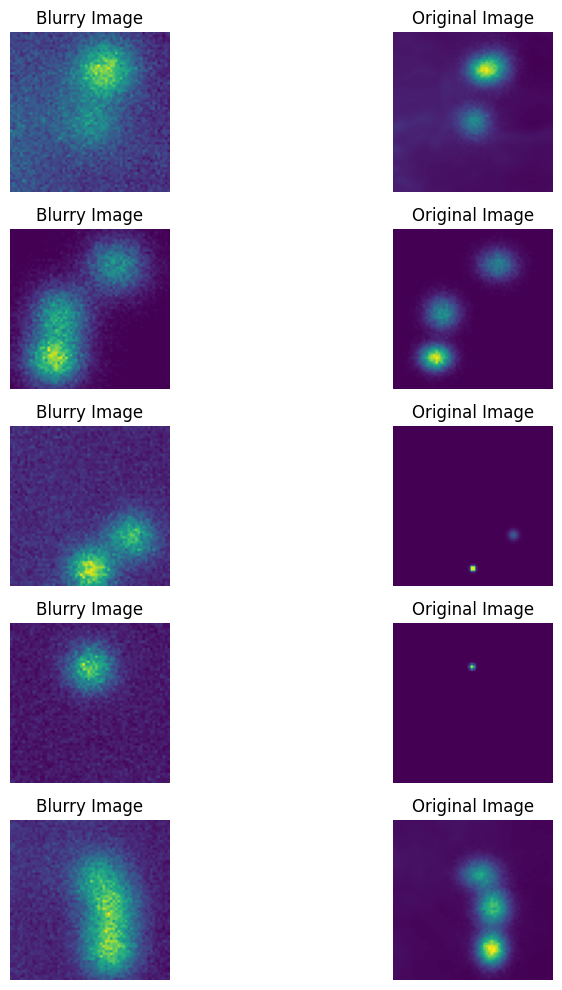

In [5]:
# 打印数据集中的一些样本
for batch_idx, (blurry_img, original_img) in enumerate(dataloader):
    continue
    print(f"Batch {batch_idx + 1}:")
    print(f"Blurry image shape: {blurry_img.shape}")
    print(f"Original image shape: {original_img.shape}")

num_images_to_show = 5
# 创建一个包含两列的图像网格，每一列显示一张模糊图像和一张原始图像
fig, axes = plt.subplots(num_images_to_show, 2, figsize=(10, 2*num_images_to_show))
# 遍历每个样本
for i in range(num_images_to_show):
    # 获取模糊图像和原始图像
    blurry_img_numpy = blurry_img[i].squeeze().detach().numpy()
    original_img_numpy = original_img[i].squeeze().detach().numpy()
    
    # 显示模糊图像
    axes[i, 0].imshow(blurry_img_numpy)
    axes[i, 0].set_title('Blurry Image')
    axes[i, 0].axis('off')
    
    # 显示原始图像
    axes[i, 1].imshow(original_img_numpy)
    axes[i, 1].set_title('Original Image')
    axes[i, 1].axis('off')

# 调整子图之间的间距
plt.tight_layout()

# 显示图像
plt.show()

In [6]:
def train(dataloader, num_epochs):
    with open(f'training.log', 'w') as nothing: # 清空原log
        pass
    log(f"Experiment name: {EXP_NAME}")
    for epoch in range(num_epochs):
        model.train() # 切换成训练模式
        total_loss = 0.0
        current_lr = LR_MIN + 0.5 * (LR_MAX - LR_MIN) * (1 + np.cos(np.pi * epoch / EPOCHS))
        optimizer = torch.optim.AdamW(model.parameters(), lr = current_lr)

        for _, (img_LR, img_HR) in enumerate(dataloader):
            # img_LR = torch.squeeze(img_LR,dim = 1).to(DEVICE)
            # img_HR = torch.squeeze(img_HR,dim = 1).to(DEVICE)
            img_LR = img_LR.to(DEVICE)
            img_HR = img_HR.to(DEVICE)
            img_SR, _, _ = model(img_LR)
            img_SR = img_SR.to(DEVICE)
            # 这步为止，img_LR,img_HR,img_SR均是[batchsize,不知道是什么,宽，高]
            #if epoch <= 500:
            #    loss = criterion1(img_SR, img_HR)
            #if epoch > 500:
            #    loss = criterion2(img_SR, img_HR) # 每个BATCH的loss，64张图平均
            loss = lossfunction(img_SR,img_HR)
            optimizer.zero_grad()
            loss.backward() # 最耗算力的一步
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader) # 每个EPOCH的loss，全部数据集的平均

        test_loss = 0.0
        for _, (img_LR, img_HR) in enumerate(testloader):
            # img_LR = torch.squeeze(img_LR,dim = 1).to(DEVICE)
            # img_HR = torch.squeeze(img_HR,dim = 1).to(DEVICE)
            img_LR = img_LR.to(DEVICE)
            img_HR = img_HR.to(DEVICE)
            img_SR, _, _ = model(img_LR)
            img_SR = img_SR.to(DEVICE)
            # 这步为止，img_LR,img_HR,img_SR均是[batchsize,不知道是什么,宽，高]
            #if epoch <= 500:
            #    loss = criterion1(img_SR, img_HR)
            #if epoch > 500:
            #    loss = criterion2(img_SR, img_HR) # 每个BATCH的loss，64张图平均
            loss = lossfunction(img_SR,img_HR)
            test_loss += loss.item()
        test_avg_loss = test_loss / len(testloader)

        
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4e}, Test Loss: {test_avg_loss:.4e}, Current_LR:{current_lr:.4f}")
        log(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4e}, Test Loss: {test_avg_loss:.4e}, Current_LR:{current_lr:.4f}")

        LOSS_PLOT.append(avg_loss)
        TESTLOSS_PLOT.append(test_avg_loss)
        EPOCH_PLOT.append(epoch)
        # if epoch % 300 == 0:
        #     torch.save(model.state_dict(), Dir.TEMP()+'/checkpoint.pth')

In [8]:
datas = np.load(filepath,allow_pickle=True)#.astype(np.object)
blurry_datas = np.stack(datas[:,1])
original_datas = np.stack(datas[:,0])

In [9]:

    
torch.set_printoptions(precision=10)
#lossfunction = ssim_function
print(f'DEVICE:{DEVICE}\n')
print(f'Training Start. \nExperiment name: {EXP_NAME}')
train(dataloader, EPOCHS)
print(f'\n Succsessfully done! Training log saved.')

DEVICE:cuda

Training Start. 
Experiment name: EXP_0_1
Epoch [1/400], Average Loss: 1.3719e-03, Test Loss: 1.1968e-03, Current_LR:0.0005
Epoch [2/400], Average Loss: 1.0894e-03, Test Loss: 1.0932e-03, Current_LR:0.0005
Epoch [3/400], Average Loss: 8.7489e-04, Test Loss: 7.7603e-04, Current_LR:0.0005
Epoch [4/400], Average Loss: 8.8256e-04, Test Loss: 7.9505e-04, Current_LR:0.0005
Epoch [5/400], Average Loss: 8.1034e-04, Test Loss: 6.7670e-04, Current_LR:0.0005
Epoch [6/400], Average Loss: 9.0352e-04, Test Loss: 6.6383e-04, Current_LR:0.0005
Epoch [7/400], Average Loss: 7.4224e-04, Test Loss: 6.3120e-04, Current_LR:0.0005
Epoch [8/400], Average Loss: 7.5068e-04, Test Loss: 6.3577e-04, Current_LR:0.0005
Epoch [9/400], Average Loss: 7.0482e-04, Test Loss: 6.1399e-04, Current_LR:0.0005
Epoch [10/400], Average Loss: 6.8214e-04, Test Loss: 6.1563e-04, Current_LR:0.0005
Epoch [11/400], Average Loss: 7.1186e-04, Test Loss: 6.7197e-04, Current_LR:0.0005
Epoch [12/400], Average Loss: 6.7444e-04,

LOSS fig saved at ../outputs/trained_models/CNN_EXP_0_1_lossfig_400epo_32bth_64latn_poissonsrc+bkg_highresorig.png
LOSS data saved at ../outputs/trained_models/CNN_EXP_0_1_lossdata_400epo_32bth_64latn_poissonsrc+bkg_highresorig.npy
MODEL saved at ../outputs/trained_models/CNN_EXP_0_1_model_400epo_32bth_64latn_poissonsrc+bkg_highresorig.pth


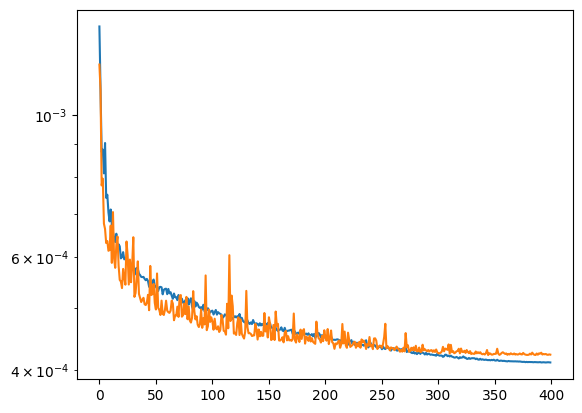

In [10]:
fig,ax = plt.subplots()
ax.plot(EPOCH_PLOT,LOSS_PLOT)
ax.plot(EPOCH_PLOT,TESTLOSS_PLOT)
ax.set_yscale('log')
fig.savefig(f'../models/{MODEL_NAME}_{EXP_NAME}_lossfig_{name}.png', dpi = 300) # 保存LOSS图片
print(f'LOSS fig saved at {Dir.models()}/{MODEL_NAME}_{EXP_NAME}_lossfig_{name}.png')

LOSS_DATA = np.stack((np.array(EPOCH_PLOT),np.array(LOSS_PLOT),np.array(TESTLOSS_PLOT)),axis=0)
np.save(f'../models/{MODEL_NAME}_{EXP_NAME}_lossdata_{name}.npy',LOSS_DATA) # 保存LOSS数据
print(f'LOSS data saved at {Dir.models()}/{MODEL_NAME}_{EXP_NAME}_lossdata_{name}.npy')

torch.save(model.state_dict(), f'../models/{MODEL_NAME}_{EXP_NAME}_model_{name}.pth') #保存模型pth
print(f'MODEL saved at {Dir.models()}/{MODEL_NAME}_{EXP_NAME}_model_{name}.pth')

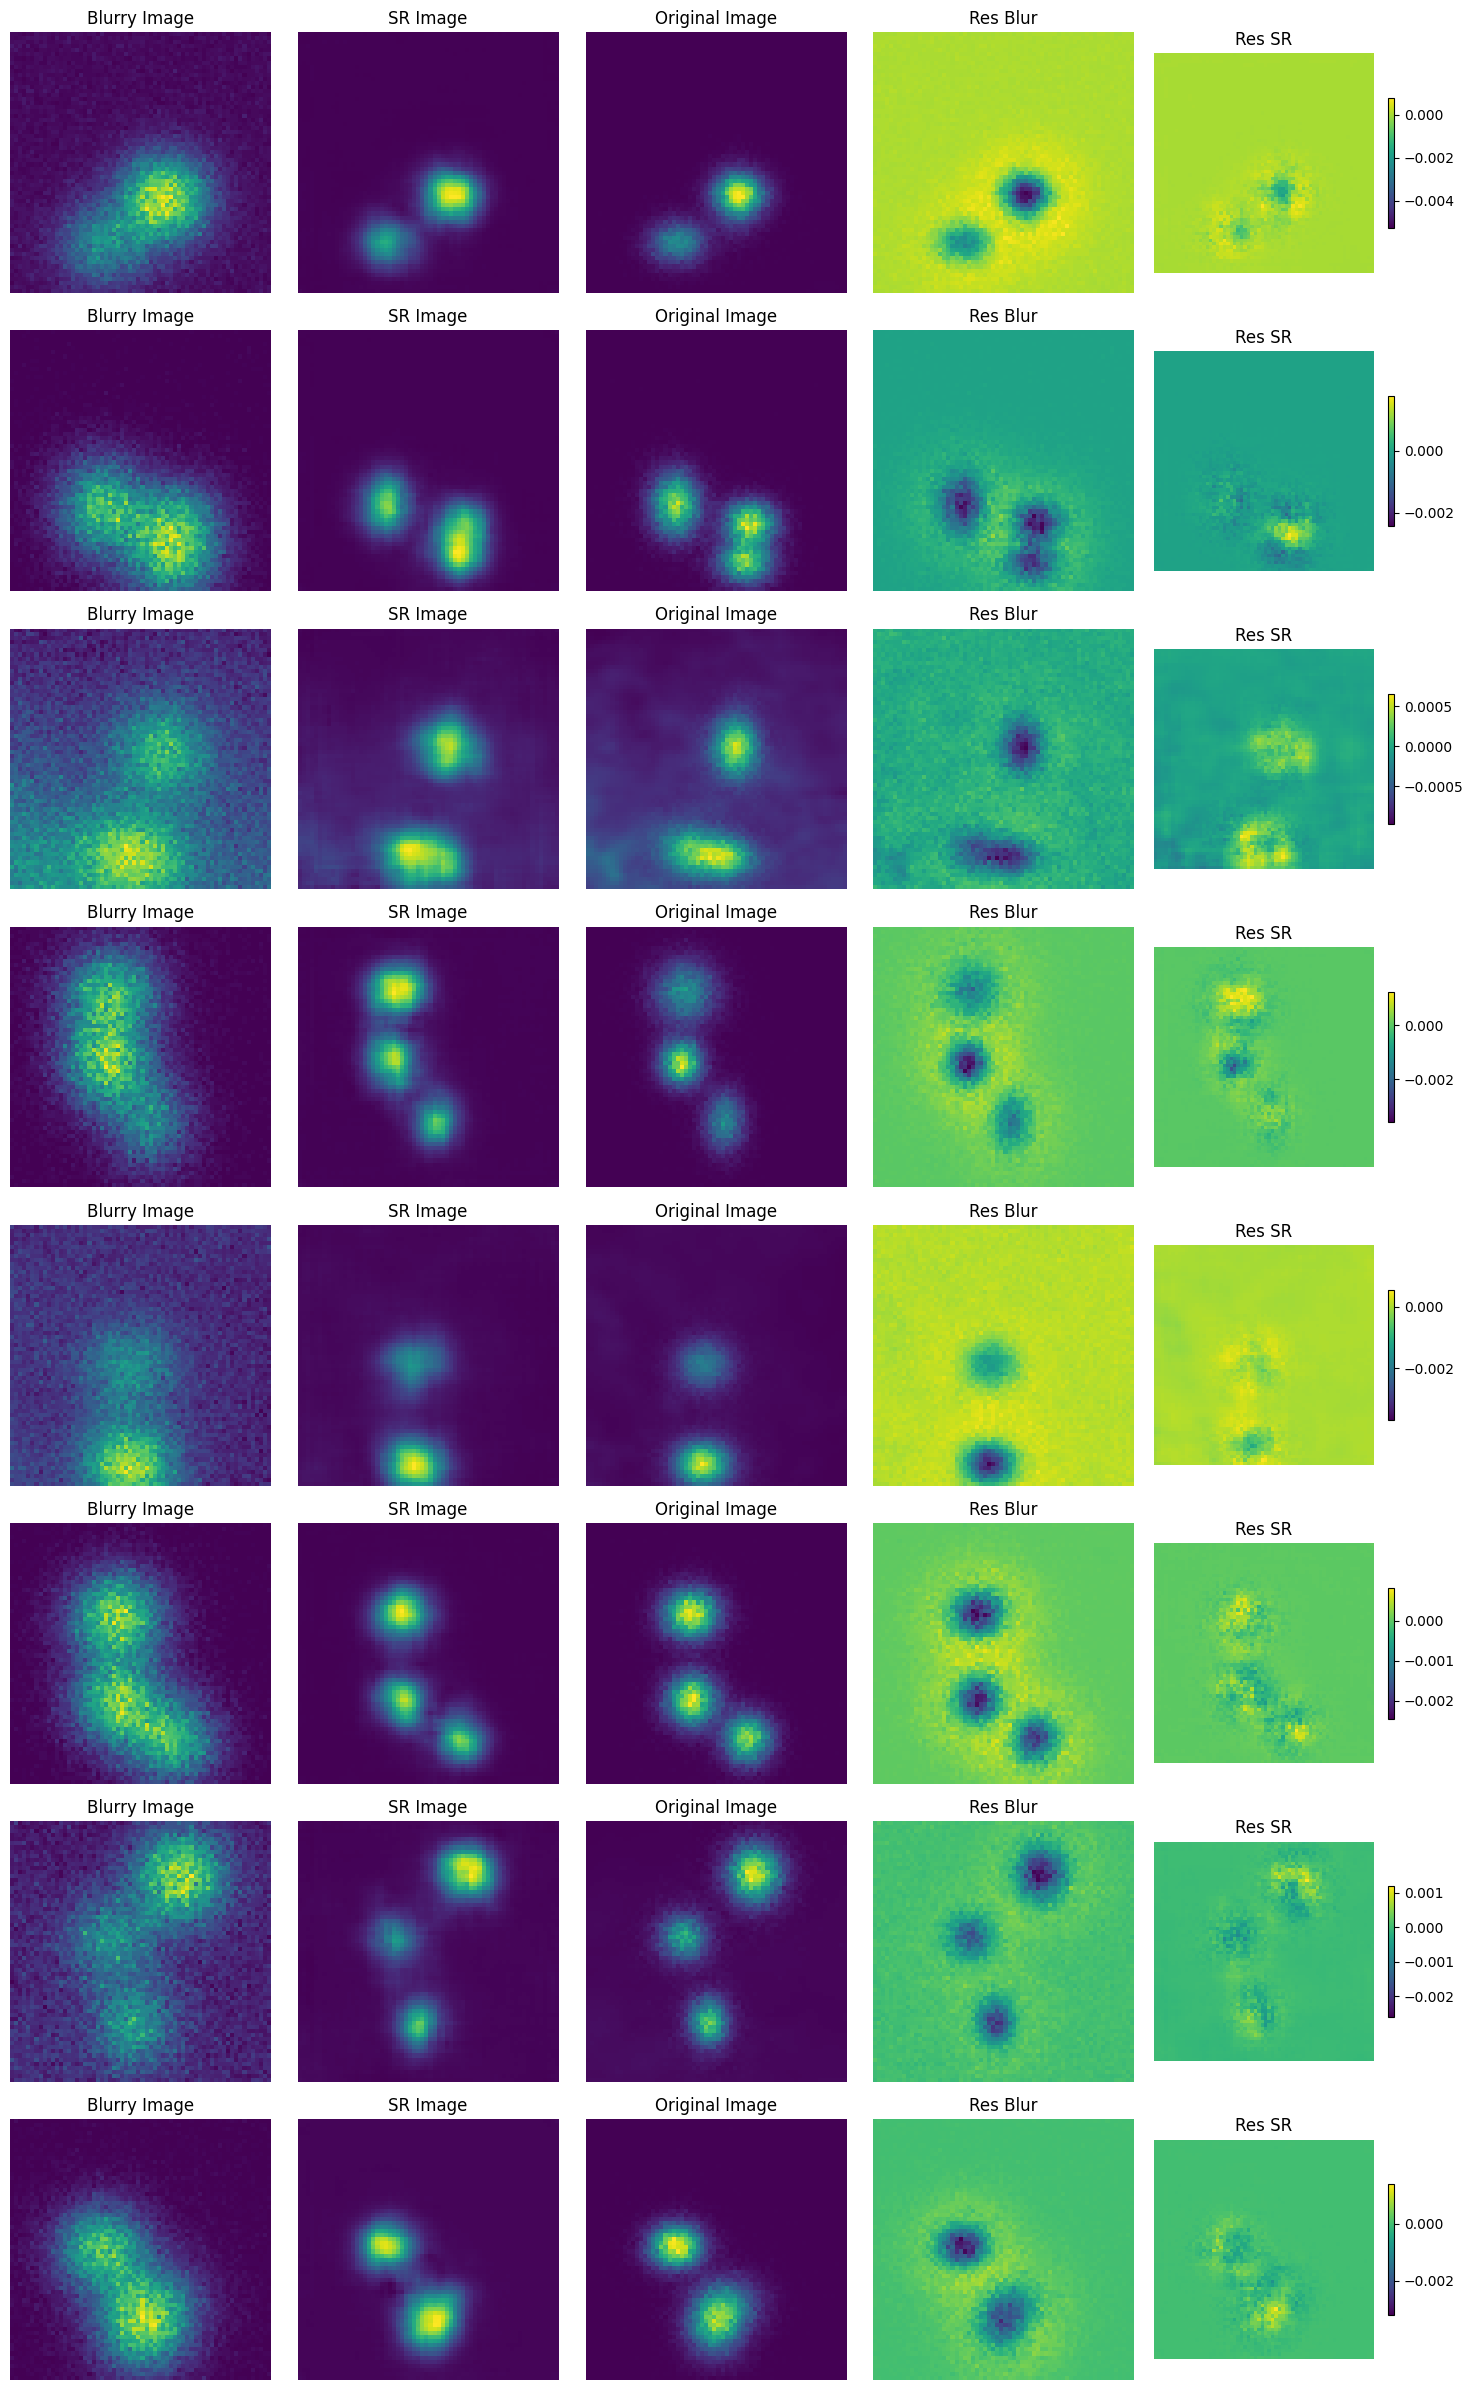

In [15]:
import torch
import matplotlib.pyplot as plt

model.eval()  # 切换到评估模式
model.to(DEVICE)

for _, (img_LR, img_HR) in enumerate(testloader):
    #print(img_LR.shape)
    img_SR, _, _ = model(img_LR.to(DEVICE))
    img_SR = img_SR.cpu()
    break

num_images_to_show = 8
# 创建一个包含三列的图像网格，每一列显示一张模糊图像、超分辨率图像和原始图像
fig, axes = plt.subplots(num_images_to_show,5 , figsize=(15, 3 * num_images_to_show))

# 遍历每个样本
for i in range(num_images_to_show):
    # 获取模糊图像、超分辨率图像和原始图像
    blurry_img_numpy = img_LR[i].squeeze().detach().cpu().numpy()
    sr_img_numpy = img_SR[i].squeeze().detach().cpu().numpy()
    original_img_numpy = img_HR[i].squeeze().detach().cpu().numpy()
    
    blurry_img_numpy =blurry_img_numpy/blurry_img_numpy.sum()
    original_img_numpy=original_img_numpy/original_img_numpy.sum()
    sr_img_numpy =sr_img_numpy/sr_img_numpy.sum() 
    
    # 显示模糊图像
    im0=axes[i, 0].imshow(blurry_img_numpy)
    axes[i, 0].set_title('Blurry Image')
    axes[i, 0].axis('off')

    # 显示超分辨率图像
    im1=axes[i, 1].imshow(sr_img_numpy)
    axes[i, 1].set_title('SR Image')
    axes[i, 1].axis('off')
    
    # 显示原始图像
    im2=axes[i, 2].imshow(original_img_numpy)
    axes[i, 2].set_title('Original Image')
    axes[i, 2].axis('off')


    
    # res_blur
    res_blur = (blurry_img_numpy-original_img_numpy)
    res_sr = (sr_img_numpy-original_img_numpy)
    vmin = min(res_blur.min(),res_sr.min())
    vmax = max(res_blur.max(),res_sr.max())
    im3= axes[i, 3].imshow(res_blur,vmin =vmin,vmax=vmax)
    axes[i, 3].set_title('Res Blur')
    axes[i, 3].axis('off')

    # res_sr
    im4 = axes[i, 4].imshow(res_sr,vmin =vmin,vmax=vmax)
    axes[i, 4].set_title('Res SR')
    axes[i, 4].axis('off')
    cbar2 = fig.colorbar(
        im4, ax=axes[i,4],shrink = 0.5
    )

# 调整子图之间的间距
plt.tight_layout()

# 显示图像
plt.show()


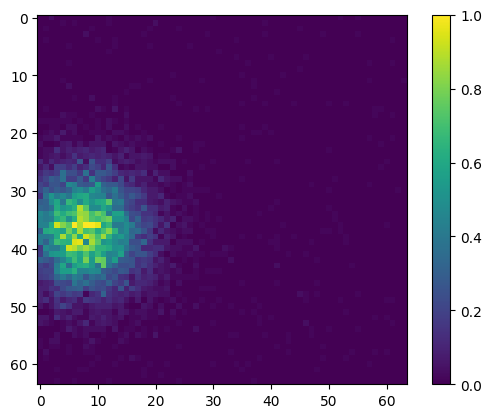

In [12]:
orig,blu = trainset.__getitem__(0)
plt.imshow(orig[0])
plt.colorbar()